In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
data=pd.read_csv("./data_paper/Force15kgf.csv")

print(data.shape)

# data가 pandas DataFrame이고, shape이 (558, 13)이라고 가정합니다.

# 'cycle', 'soh', 'DVSOC50' 열을 제외하고 나머지 데이터만 유지
# 여기서 'cycle'이 2개 있다고 하셨으니, 구체적인 열 이름이 필요할 수 있습니다.
# 예를 들어, 'cycle1', 'cycle2' 같이 구분이 되어 있다면 아래와 같이 작성합니다.
data_reduced = data.drop(['Unnamed: 0', 'Cycle', 'SOH', 'DVSOC50'], axis=1)

# 결과 확인
print(data_reduced.shape)  # 이제 (558, 9)가 되어야 합니다.
data_reduced.head()

(558, 13)
(558, 9)


,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS (dt),CVES (dt),DIV
0,1357.5,1283.5,72.82119,2.4414,11.036,1.680,0.01614,0.000072,2.5081
1,1357.7,1285.9,72.41452,2.7008,11.118,1.590,0.02041,0.000160,2.5014
2,1357.7,1286.0,72.05853,2.7048,11.090,1.680,0.02021,0.000129,2.5023
3,1357.8,1286.5,71.75321,2.7065,11.042,1.636,0.01887,0.000146,2.5049
4,1357.9,1286.7,71.49856,2.7071,11.020,1.624,0.01857,0.000180,2.5057


In [25]:
# 예제 데이터프레임 생성 (558, 9) 형태라고 가정
# data = pd.DataFrame(...)

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()

# 데이터 정규화 수행
data_normalized = scaler.fit_transform(data_reduced)

# 정규화된 데이터를 다시 DataFrame으로 변환
data_normalized = pd.DataFrame(data_normalized, columns=data_reduced.columns)

# 정규화된 데이터 확인
data_normalized.head()

,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS (dt),CVES (dt),DIV
0,0.023061,0.008609,0.757808,0.000000,0.881159,1.000000,0.346095,0.043789,0.514870
1,0.024708,0.027392,0.693661,0.448014,1.000000,0.720497,1.000000,0.384692,0.390335
2,0.024708,0.028175,0.637508,0.454922,0.959420,1.000000,0.969372,0.263696,0.407063
3,0.025532,0.032088,0.589348,0.457858,0.889855,0.863354,0.764165,0.329476,0.455390
4,0.026355,0.033653,0.549180,0.458895,0.857971,0.826087,0.718224,0.461515,0.470260


In [46]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import random

# 난수 생성기 시드 설정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

def build_autoencoder(input_dim, encoding_dim):
    # 입력 레이어
    input_layer = Input(shape=(input_dim,))
    
    # 인코더 레이어: 입력을 encoding_dim 차원으로 압축, He 초기화 사용
    encoded = Dense(encoding_dim[0], activation='elu', kernel_initializer='glorot_uniform')(input_layer)
    encoded = Dense(encoding_dim[1], activation='elu', kernel_initializer='glorot_uniform')(encoded)
    
    # 디코더 레이어: encoding_dim 차원을 다시 입력 차원으로 복원, He 초기화 사용
    decoded = Dense(encoding_dim[0], activation='elu', kernel_initializer='glorot_uniform')(encoded)
    decoded = Dense(input_dim, activation='elu', kernel_initializer='glorot_uniform')(decoded)
    
    # 오토인코더 모델 생성
    autoencoder = Model(input_layer, decoded)
    
    # 인코더 모델 생성
    encoder = Model(input_layer, encoded)
    
    # 디코더 모델 생성
    encoded_input = Input(shape=(encoding_dim[1],))
    decoder_layer1 = autoencoder.layers[-2](encoded_input)
    decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
    decoder = Model(encoded_input, decoder_layer2)
    
    return autoencoder, encoder, decoder

# 모델 구축
input_dim = 9  # 입력 차원
encoding_dim = [6, 4]  # 인코더의 두 레이어에서의 차원
autoencoder, encoder, decoder = build_autoencoder(input_dim, encoding_dim)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 9)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 60        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_27 (Dense)             (None, 9)                 63        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [47]:
# data.shape는 (558, 9)입니다.

# 첫 277개 행을 훈련 데이터로 사용
X_train = data_normalized

# 모델 훈련
autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, shuffle=False, validation_split=0.2)

# 테스트 데이터에 대한 재구성
reconstructed = autoencoder.predict(X_train)

# 재구성 오류 계산
reconstruction_error = np.mean((X_train - reconstructed)**2)
print("재구성 오류:", reconstruction_error)


Train on 446 samples, validate on 112 samples
Epoch 1/200
446/446 [==============================] - 0s 612us/sample - loss: 0.3307 - val_loss: 0.3575
Epoch 2/200
446/446 [==============================] - 0s 110us/sample - loss: 0.2777 - val_loss: 0.3139
Epoch 3/200
446/446 [==============================] - 0s 90us/sample - loss: 0.2364 - val_loss: 0.2771
Epoch 4/200
446/446 [==============================] - 0s 101us/sample - loss: 0.1998 - val_loss: 0.2475
Epoch 5/200
446/446 [==============================] - 0s 96us/sample - loss: 0.1663 - val_loss: 0.2235
Epoch 6/200
446/446 [==============================] - 0s 112us/sample - loss: 0.1360 - val_loss: 0.2043
Epoch 7/200
446/446 [==============================] - 0s 72us/sample - loss: 0.1093 - val_loss: 0.1893
Epoch 8/200
446/446 [==============================] - 0s 87us/sample - loss: 0.0863 - val_loss: 0.1776
Epoch 9/200
446/446 [==============================] - 0s 85us/sample - loss: 0.0673 - val_loss: 0.1686
Epoch 10/200
4

446/446 [==============================] - 0s 58us/sample - loss: 0.0091 - val_loss: 0.0897
Epoch 79/200
446/446 [==============================] - 0s 56us/sample - loss: 0.0090 - val_loss: 0.0889
Epoch 80/200
446/446 [==============================] - 0s 54us/sample - loss: 0.0089 - val_loss: 0.0880
Epoch 81/200
446/446 [==============================] - 0s 54us/sample - loss: 0.0088 - val_loss: 0.0872
Epoch 82/200
446/446 [==============================] - 0s 54us/sample - loss: 0.0088 - val_loss: 0.0864
Epoch 83/200
446/446 [==============================] - 0s 54us/sample - loss: 0.0087 - val_loss: 0.0855
Epoch 84/200
446/446 [==============================] - 0s 54us/sample - loss: 0.0086 - val_loss: 0.0847
Epoch 85/200
446/446 [==============================] - 0s 54us/sample - loss: 0.0086 - val_loss: 0.0838
Epoch 86/200
446/446 [==============================] - 0s 52us/sample - loss: 0.0085 - val_loss: 0.0830
Epoch 87/200
446/446 [==============================] - 0s 54us/samp

446/446 [==============================] - 0s 63us/sample - loss: 0.0047 - val_loss: 0.0339
Epoch 156/200
446/446 [==============================] - 0s 63us/sample - loss: 0.0047 - val_loss: 0.0333
Epoch 157/200
446/446 [==============================] - 0s 65us/sample - loss: 0.0046 - val_loss: 0.0328
Epoch 158/200
446/446 [==============================] - 0s 61us/sample - loss: 0.0046 - val_loss: 0.0323
Epoch 159/200
446/446 [==============================] - 0s 65us/sample - loss: 0.0045 - val_loss: 0.0318
Epoch 160/200
446/446 [==============================] - 0s 63us/sample - loss: 0.0045 - val_loss: 0.0314
Epoch 161/200
446/446 [==============================] - 0s 63us/sample - loss: 0.0045 - val_loss: 0.0309
Epoch 162/200
446/446 [==============================] - 0s 61us/sample - loss: 0.0044 - val_loss: 0.0304
Epoch 163/200
446/446 [==============================] - 0s 61us/sample - loss: 0.0044 - val_loss: 0.0299
Epoch 164/200
446/446 [==============================] - 0s 

In [48]:
print(reconstructed.shape)
print(reconstructed)

(558, 9)
[[-0.09291226 -0.11812186  0.49430877 ...  0.6076803   0.06465825
   0.57714814]
 [-0.05042255 -0.07378143  0.4247203  ...  0.7849922   0.3755407
   0.45247728]
 [-0.06831789 -0.0942983   0.43143106 ...  0.7824509   0.33559468
   0.46774918]
 ...
 [ 0.88257366  0.7231828   0.27621928 ...  0.18924698  0.5655769
   0.26787475]
 [ 0.8480826   0.6948625   0.24551572 ...  0.2548263   0.664333
   0.21060486]
 [ 0.8806471   0.704286    0.23970671 ...  0.3309597   0.77400625
   0.18305932]]


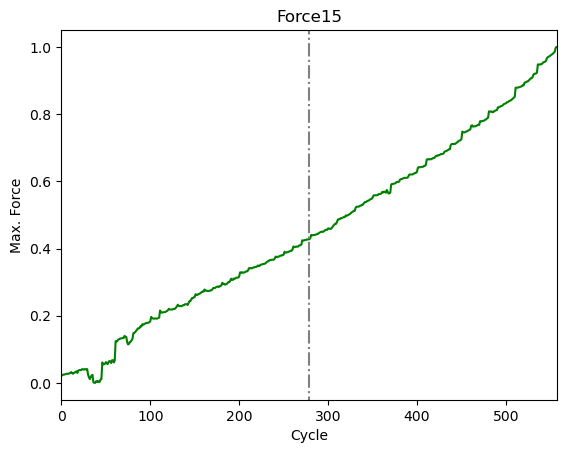

In [49]:
y= data_normalized['max.']
x= np.arange(1, len(y) + 1)
plt.plot(x,y,'g-')
plt.title("Force15")
plt.xlabel("Cycle")
plt.ylabel("Max. Force")
plt.xlim([0,len(x)])

plt.axvline(len(x)/2,-0.2,1.2,color='gray',linestyle='dashdot')

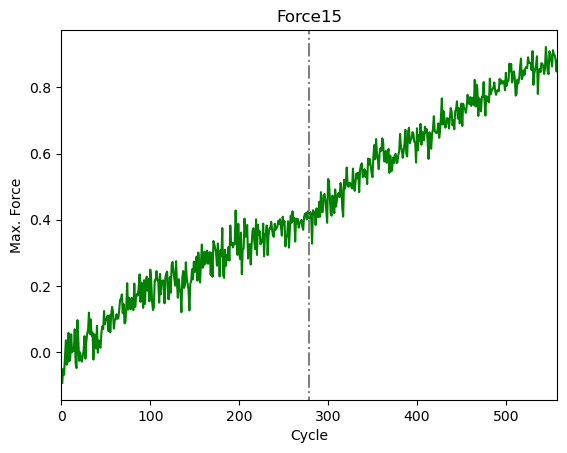

In [50]:
y= reconstructed[:,0]
x= np.arange(1, len(y) + 1)
plt.plot(x,y,'g-')
plt.title("Force15")
plt.xlabel("Cycle")
plt.ylabel("Max. Force")
plt.xlim([0,len(x)])

plt.axvline(len(x)/2,-0.2,1.2,color='gray',linestyle='dashdot')